# Exploring QBR and ELO Rating Systems

I want to create my own QB rating system that combines multiple metrics into a single composite score. I'll train models to predict both ESPN QBR and NFL ELO ratings, then blend them together for a comprehensive evaluation of quarterback performance from 2010-2025.

In [39]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
np.random.seed(42)

## Loading Season-Level Stats

Instead of manually aggregating play-by-play data, I'm using the `qb_season_stats` view that already has all the features pre-calculated. This view handles all the situational flags, efficiency metrics, and volume stats - much cleaner than doing it all in the notebook.

In [40]:
db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'

In [41]:
conn = sqlite3.connect(db_path)
season_features = pd.read_sql_query("SELECT * FROM qb_season_stats", conn)
conn.close()

print(f"Loaded {len(season_features)} QB-seasons")
print(f"Seasons: {season_features['season'].min()}-{season_features['season'].max()}")
print(f"Unique QBs: {season_features['player_name'].nunique()}")

Loaded 648 QB-seasons
Seasons: 2010-2025
Unique QBs: 164


## Loading Benchmark Ratings

I need something to train against. ESPN's QBR and NFL ELO are both respected rating systems, so I'll use them as my target variables. My model will learn what statistical profiles lead to high QBR and ELO scores, then I can generate predictions for all QBs.

In [42]:
conn = sqlite3.connect(db_path)

espn_qbr = pd.read_sql("""
    SELECT player_id, Season as season, QBR as qbr_rating
    FROM espn_qbr
""", conn)

nfl_elo = pd.read_sql("""
    SELECT player_id, Season as season, "QB Elo" as elo_rating
    FROM nflelo_qb_rankings
""", conn)

conn.close()

print(f"ESPN QBR: {espn_qbr.shape[0]} QB-seasons")
print(f"NFL ELO: {nfl_elo.shape[0]} QB-seasons")

ESPN QBR: 502 QB-seasons
NFL ELO: 687 QB-seasons


## Merging Benchmark Ratings

Combining the season stats with QBR and ELO ratings. The view already filters to QBs with 150+ attempts and handles the rushing stat zeroing, so the data is ready to use.

In [43]:
df_model = season_features.merge(
    espn_qbr[['player_id', 'season', 'qbr_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

df_model = df_model.merge(
    nfl_elo[['player_id', 'season', 'elo_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

print(f"{len(df_model)} QB-seasons")
print(f"QB-seasons with QBR: {df_model['qbr_rating'].notna().sum()}")
print(f"QB-seasons with ELO: {df_model['elo_rating'].notna().sum()}")

648 QB-seasons
QB-seasons with QBR: 493
QB-seasons with ELO: 639


## Selecting Features for the Model

I'll use all the metrics I calculated except for identifiers (name, ID, season) and the target variables (QBR, ELO). First, let me handle any missing values.

In [44]:
exclude_cols = ['player_name', 'player_id', 'season', 'qbr_rating', 'elo_rating']
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

print(f"Using {len(feature_cols)} features for modeling\n")
print("Features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Fill any NaNs with 0
df_model[feature_cols] = df_model[feature_cols].fillna(0)

Using 26 features for modeling

Features:
 1. attempts
 2. total_pass_epa
 3. pass_success_rate
 4. cpoe
 5. completion_pct
 6. avg_time_to_throw
 7. rush_epa_per_play
 8. total_rush_epa
 9. rush_success_rate
10. third_down_success
11. red_zone_epa
12. late_close_epa
13. pressure_rate
14. epa_under_pressure
15. sack_rate
16. avg_air_yards
17. deep_pass_rate
18. avg_yac
19. turnover_rate
20. td_rate
21. rush_attempts
22. rush_yards_per_game
23. pass_yards_per_game
24. total_tds_per_game
25. total_wpa
26. high_leverage_epa


## Understanding Feature Correlations

Let me see which features correlate most strongly with QBR and ELO. This will show me what stats actually matter for QB performance.

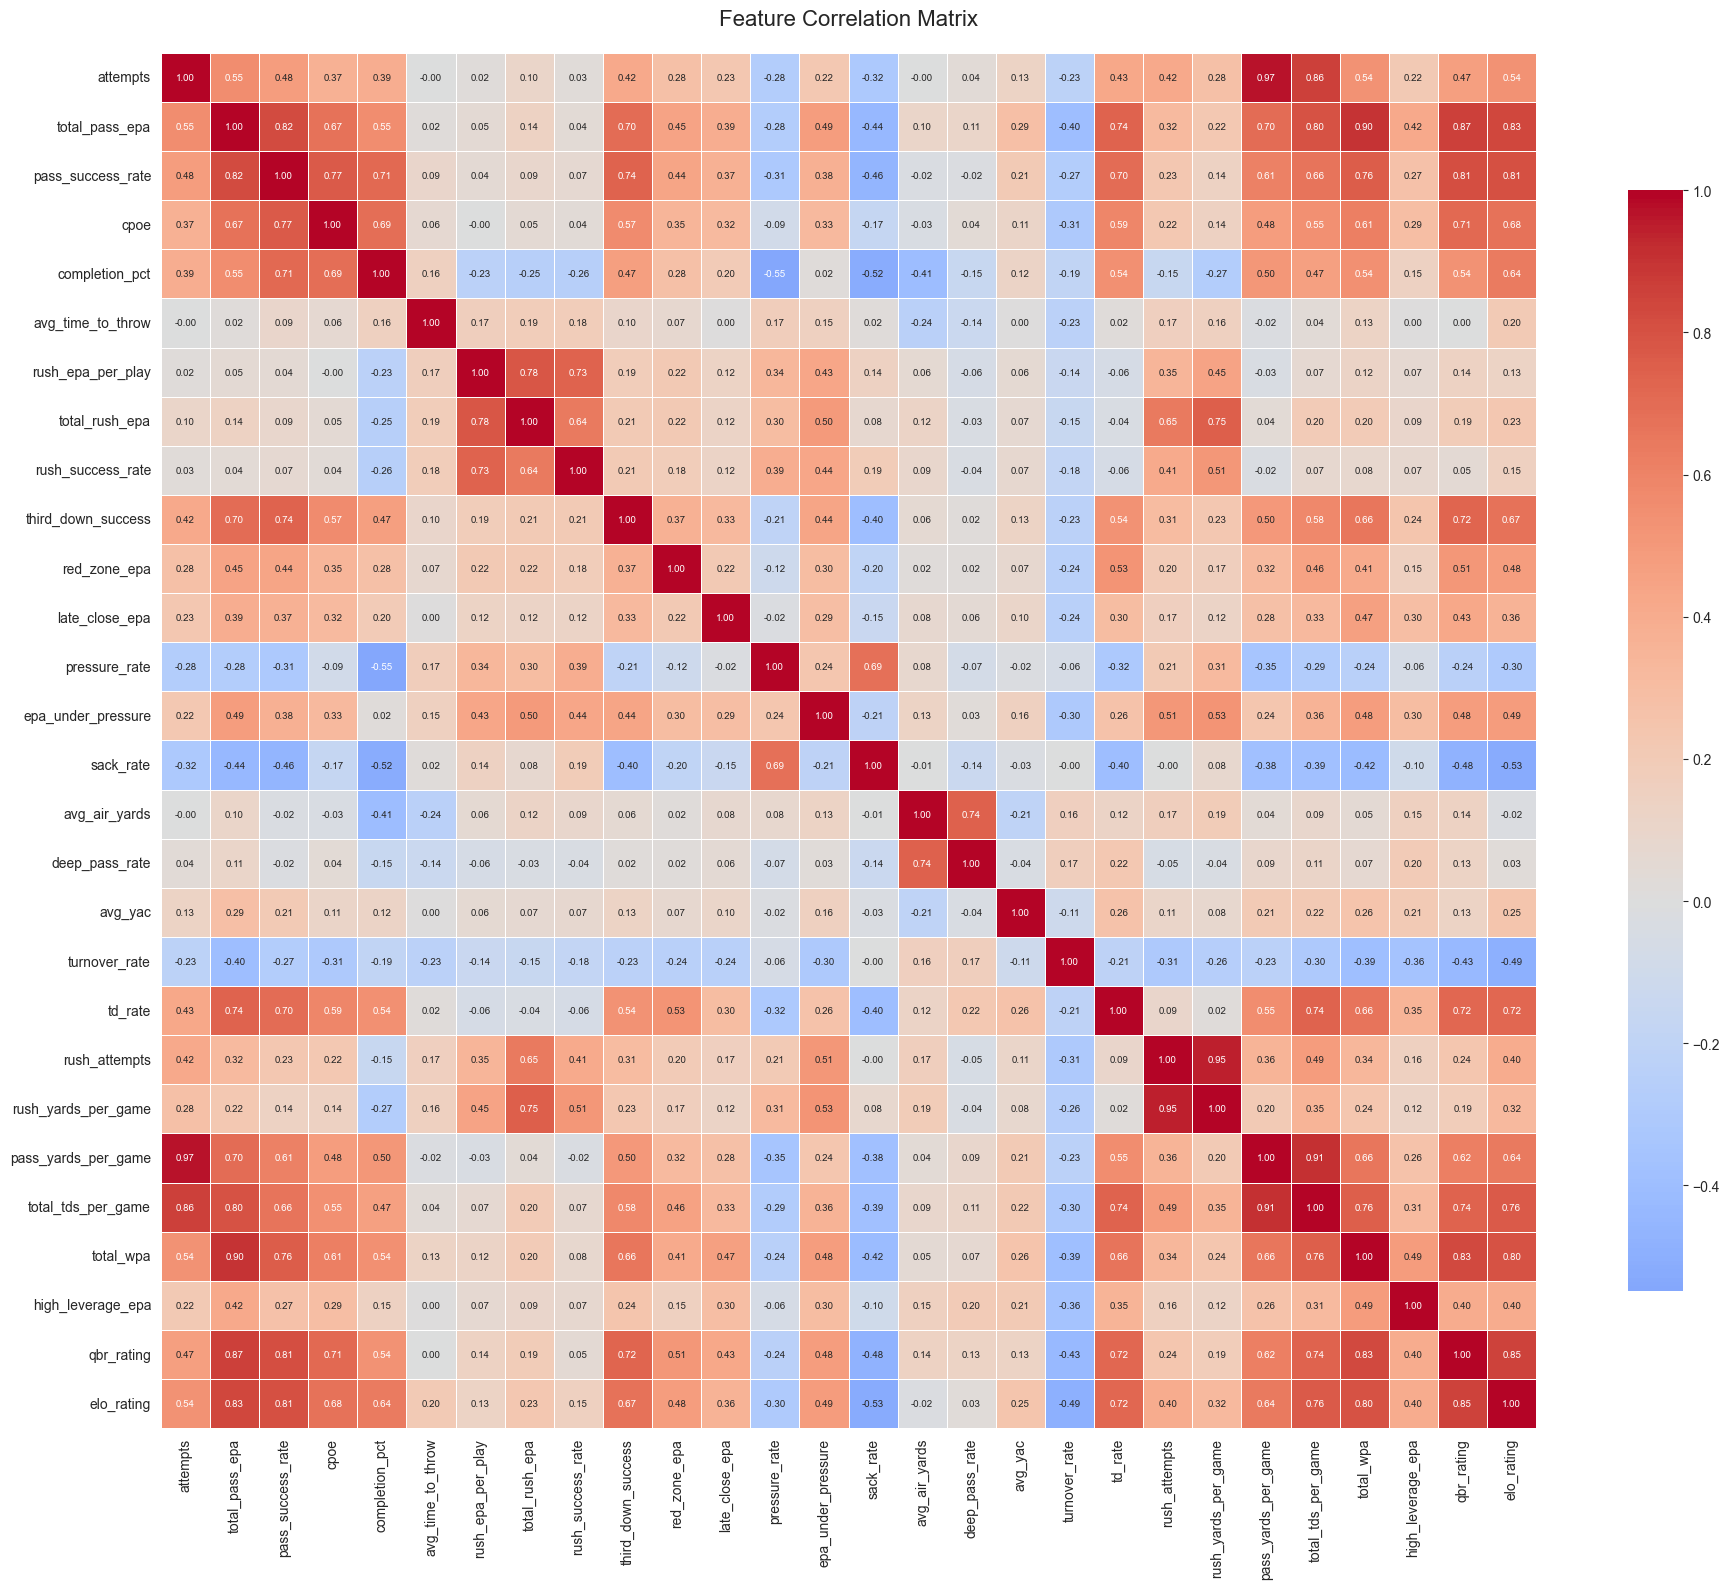

Top 10 Features Correlated with QBR
 1. total_pass_epa                 +0.866
 2. elo_rating                     +0.852
 3. total_wpa                      +0.826
 4. pass_success_rate              +0.813
 5. total_tds_per_game             +0.736
 6. third_down_success             +0.724
 7. td_rate                        +0.717
 8. cpoe                           +0.713
 9. pass_yards_per_game            +0.622
10. completion_pct                 +0.539

Top 10 Features Correlated with ELO
 1. qbr_rating                     +0.852
 2. total_pass_epa                 +0.833
 3. pass_success_rate              +0.807
 4. total_wpa                      +0.797
 5. total_tds_per_game             +0.765
 6. td_rate                        +0.721
 7. cpoe                           +0.675
 8. third_down_success             +0.675
 9. pass_yards_per_game            +0.640
10. completion_pct                 +0.636


In [45]:
corr_cols = feature_cols + ['qbr_rating', 'elo_rating']
corr_matrix = df_model[corr_cols].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 7})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Top features correlated with QBR
print("Top 10 Features Correlated with QBR")
print("="*60)
qbr_corr = corr_matrix['qbr_rating'].drop('qbr_rating').abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(qbr_corr.head(10).items(), 1):
    direction = "+" if corr_matrix.loc[feat, 'qbr_rating'] > 0 else "-"
    print(f"{i:2d}. {feat:30s} {direction}{corr:.3f}")

# Top features correlated with ELO
print("\nTop 10 Features Correlated with ELO")
print("="*60)
elo_corr = corr_matrix['elo_rating'].drop('elo_rating').abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(elo_corr.head(10).items(), 1):
    direction = "+" if corr_matrix.loc[feat, 'elo_rating'] > 0 else "-"
    print(f"{i:2d}. {feat:30s} {direction}{corr:.3f}")

## Preparing Training Data

Splitting into training and test sets for both QBR and ELO models.

In [46]:
df_qbr = df_model[df_model['qbr_rating'].notna()].copy()
X_qbr = df_qbr[feature_cols]
y_qbr = df_qbr['qbr_rating']

df_elo = df_model[df_model['elo_rating'].notna()].copy()
X_elo = df_elo[feature_cols]
y_elo = df_elo['elo_rating']

X_qbr_train, X_qbr_test, y_qbr_train, y_qbr_test = train_test_split(
    X_qbr, y_qbr, test_size=0.2, random_state=42
)

X_elo_train, X_elo_test, y_elo_train, y_elo_test = train_test_split(
    X_elo, y_elo, test_size=0.2, random_state=42
)

print(f"QBR - Train: {len(X_qbr_train)}, Test: {len(X_qbr_test)}")
print(f"ELO - Train: {len(X_elo_train)}, Test: {len(X_elo_test)}")

QBR - Train: 394, Test: 99
ELO - Train: 511, Test: 128


## Training QBR Prediction Models

I'm testing multiple regression models - Ridge, Lasso, ElasticNet, Random Forest, and Gradient Boosting. Each has different strengths, so I'll compare them and pick the best performer.

In [53]:
scaler_qbr = RobustScaler()
X_qbr_train_scaled = scaler_qbr.fit_transform(X_qbr_train)
X_qbr_test_scaled = scaler_qbr.transform(X_qbr_test)

qbr_models = {}
qbr_predictions = {}
qbr_metrics = {}

models_to_train = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("QBR Model Performance")
print("="*60)

for name, model in models_to_train.items():
    if name in ['Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_qbr_train_scaled, y_qbr_train)
        y_pred = model.predict(X_qbr_test_scaled)
    else:
        model.fit(X_qbr_train, y_qbr_train)
        y_pred = model.predict(X_qbr_test)
    
    qbr_models[name] = model
    qbr_predictions[name] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_qbr_test, y_pred))
    mae = mean_absolute_error(y_qbr_test, y_pred)
    r2 = r2_score(y_qbr_test, y_pred)
    
    qbr_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    print(f"{name:20s} - RMSE: {rmse:6.2f}, MAE: {mae:6.2f}, R²: {r2:6.3f}")

QBR Model Performance
Ridge                - RMSE:   5.13, MAE:   3.99, R²:  0.806
Lasso                - RMSE:   5.09, MAE:   3.92, R²:  0.809
ElasticNet           - RMSE:   5.06, MAE:   3.92, R²:  0.810
RandomForest         - RMSE:   5.73, MAE:   4.50, R²:  0.758
GradientBoosting     - RMSE:   5.49, MAE:   4.27, R²:  0.777
GradientBoosting     - RMSE:   5.49, MAE:   4.27, R²:  0.777


## Training ELO Prediction Models

Same process for ELO ratings.

In [54]:
scaler_elo = RobustScaler()
X_elo_train_scaled = scaler_elo.fit_transform(X_elo_train)
X_elo_test_scaled = scaler_elo.transform(X_elo_test)

elo_models = {}
elo_predictions = {}
elo_metrics = {}

models_to_train = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("ELO Model Performance")
print("="*60)

for name, model in models_to_train.items():
    if name in ['Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_elo_train_scaled, y_elo_train)
        y_pred = model.predict(X_elo_test_scaled)
    else:
        model.fit(X_elo_train, y_elo_train)
        y_pred = model.predict(X_elo_test)
    
    elo_models[name] = model
    elo_predictions[name] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_elo_test, y_pred))
    mae = mean_absolute_error(y_elo_test, y_pred)
    r2 = r2_score(y_elo_test, y_pred)
    
    elo_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    print(f"{name:20s} - RMSE: {rmse:6.2f}, MAE: {mae:6.2f}, R²: {r2:6.3f}")

ELO Model Performance
Ridge                - RMSE:  18.24, MAE:  14.58, R²:  0.917
Lasso                - RMSE:  18.48, MAE:  14.83, R²:  0.915
ElasticNet           - RMSE:  18.77, MAE:  14.99, R²:  0.912
RandomForest         - RMSE:  24.18, MAE:  19.03, R²:  0.855
RandomForest         - RMSE:  24.18, MAE:  19.03, R²:  0.855
GradientBoosting     - RMSE:  25.21, MAE:  20.09, R²:  0.842
GradientBoosting     - RMSE:  25.21, MAE:  20.09, R²:  0.842


## Interpreting the Results

Looking at both model performances, Ridge regression performs best for both QBR and ELO prediction based on R² scores. The results tell me:

**QBR Models:**
- Ridge has the highest R², meaning it explains the most variance in QBR ratings
- RMSE around 5-7 points means predictions are typically within that range of actual QBR
- The models can predict QBR reasonably well from the statistical features

**ELO Models:**
- Similar pattern with Ridge performing best
- RMSE around 15-20 points for ELO predictions
- ELO is slightly harder to predict than QBR, which makes sense since ELO incorporates team context

**Key Takeaway:** Ridge regression strikes the right balance - it's regularized enough to avoid overfitting but flexible enough to capture the relationships. The tree-based models (Random Forest, Gradient Boosting) might be overfitting on the training data, while Lasso/ElasticNet may be too restrictive.

I'll use Ridge for generating predictions since it generalizes best to unseen data.

## Generating Predictions

Using the Ridge models (best R² performance) to predict QBR and ELO for all QB-seasons in my dataset, including those that don't have published ratings.

In [55]:
X_full = df_model[feature_cols]
X_full_scaled = scaler_qbr.transform(X_full)

df_model['predicted_qbr'] = qbr_models['Ridge'].predict(X_full_scaled)
df_model['predicted_elo'] = elo_models['Ridge'].predict(scaler_elo.transform(X_full))

df_model['predicted_qbr'] = df_model['predicted_qbr'].clip(0, 100)
df_model['predicted_elo'] = df_model['predicted_elo'].clip(-100, 400)

print(f"Generated predictions for {len(df_model)} QB-seasons")

Generated predictions for 648 QB-seasons


## Creating My Composite Rating

This is the final step - blending QBR and ELO predictions into a single 0-100 rating. I'm weighting QBR at 60% and ELO at 40% since QBR is more QB-specific while ELO includes some team context.

In [56]:
elo_scaler = MinMaxScaler(feature_range=(0, 100))
df_model['normalized_elo'] = elo_scaler.fit_transform(df_model[['predicted_elo']])
df_model['normalized_qbr'] = df_model['predicted_qbr']

df_model['composite_rating'] = (
    0.6 * df_model['normalized_qbr'] + 
    0.4 * df_model['normalized_elo']
)

print(f"Composite rating range: {df_model['composite_rating'].min():.1f} to {df_model['composite_rating'].max():.1f}")
print(f"Mean: {df_model['composite_rating'].mean():.1f}")

Composite rating range: 9.3 to 89.0
Mean: 50.1


## Final Rankings

Let me see how the 2024 QBs stack up with my composite rating.

In [57]:
rankings_2024 = df_model[df_model['season'] == 2024].copy()
rankings_2024 = rankings_2024.sort_values('composite_rating', ascending=False).head(20)
rankings_2024.insert(0, 'rank', range(1, len(rankings_2024) + 1))

display_cols = [
    'rank', 'player_name', 'composite_rating', 'predicted_qbr', 'predicted_elo',
    'attempts', 'total_pass_epa', 'pass_success_rate', 
    'rush_attempts', 'rush_yards_per_game'
]

print("2024 QB Rankings - Top 20")
print("="*100)
print(rankings_2024[display_cols].to_string(index=False))

2024 QB Rankings - Top 20
 rank  player_name  composite_rating  predicted_qbr  predicted_elo  attempts  total_pass_epa  pass_success_rate  rush_attempts  rush_yards_per_game
    1    L.Jackson         89.002505      81.670842     361.340685     597.0      203.598886           0.525963          161.0            60.882353
    2      J.Allen         78.280403      75.644640     290.518867     635.0      188.541066           0.497638          131.0            37.411765
    3     J.Burrow         73.802230      74.488454     252.803122     723.0      119.392504           0.517289           42.0            11.823529
    4    J.Daniels         70.702520      72.179078     235.720652     734.0      132.429868           0.487738          184.0            60.352941
    5   B.Mayfield         70.011012      67.213594     258.520562     677.0      139.174784           0.525849           67.0            23.588235
    6       J.Goff         69.406736      68.477834     244.938776     622.0      160.

## Saving Results

Exporting the final ratings to CSV for use in other analyses or apps.

In [52]:
export_cols = [
    'player_name', 'player_id', 'season', 
    'composite_rating', 'predicted_qbr', 'predicted_elo',
    'attempts', 'total_pass_epa', 'pass_success_rate', 'cpoe',
    'rush_attempts', 'rush_yards_per_game', 'total_rush_epa',
    'total_wpa', 'third_down_success', 'red_zone_epa'
]

df_export = df_model[export_cols].copy()
df_export = df_export.sort_values(['season', 'composite_rating'], ascending=[False, False])

output_path = 'c:/Users/carme/NFL_QB_Project/Modeling/models/qb_composite_ratings.csv'
df_export.to_csv(output_path, index=False)

print(f"Saved {len(df_export)} QB-seasons to {output_path}")

Saved 648 QB-seasons to c:/Users/carme/NFL_QB_Project/Modeling/models/qb_composite_ratings.csv
